In [170]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt


train = pd.read_csv('train.csv', parse_dates = True, low_memory = False, index_col = 'Date')
store = pd.read_csv('store.csv', low_memory = False)


In [171]:
# train = train.merge(store, on = 'Store', how = 'left')
# train = train.dropna()
# train = train.reset_index(drop = True)

# train['Year'] = train['Date'].dt.year
# train['Month'] = train['Date'].dt.month
# train['Day'] = train['Date'].dt.day
# train['WeekOfYear'] = train['Date'].dt.weekofyear

# Lets add a feature for the number of days since the competition opened
# train['CompetitionOpen'] = 12 * (train.Year - train.CompetitionOpenSinceYear) + (train.Month - train.CompetitionOpenSinceMonth)
# train['CompetitionOpen'] = train['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)

# train['PromoOpen'] = 12 * (train.Year - train.Promo2SinceYear) + (train.WeekOfYear - train.Promo2SinceWeek) / 4.0
# train['PromoOpen'] = train['PromoOpen'].apply(lambda x: x if x > 0 else 0)

# train['PromoInterval'].fillna(0, inplace = True)
# train['IsPromoMonth'] = 0
# for interval in train.PromoInterval.unique():
#     if interval != 0:
#         for month in interval.split(','):
#             train.loc[(train.Month == int(month)) & (train.PromoInterval == interval), 'IsPromoMonth'] = 1

# train['StateHoliday'] = train['StateHoliday'].apply(lambda x: 1 if x == 'a' else 0)

# train['StoreType'] = train['StoreType'].apply(lambda x: 1 if x == 'a' else 0)



,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


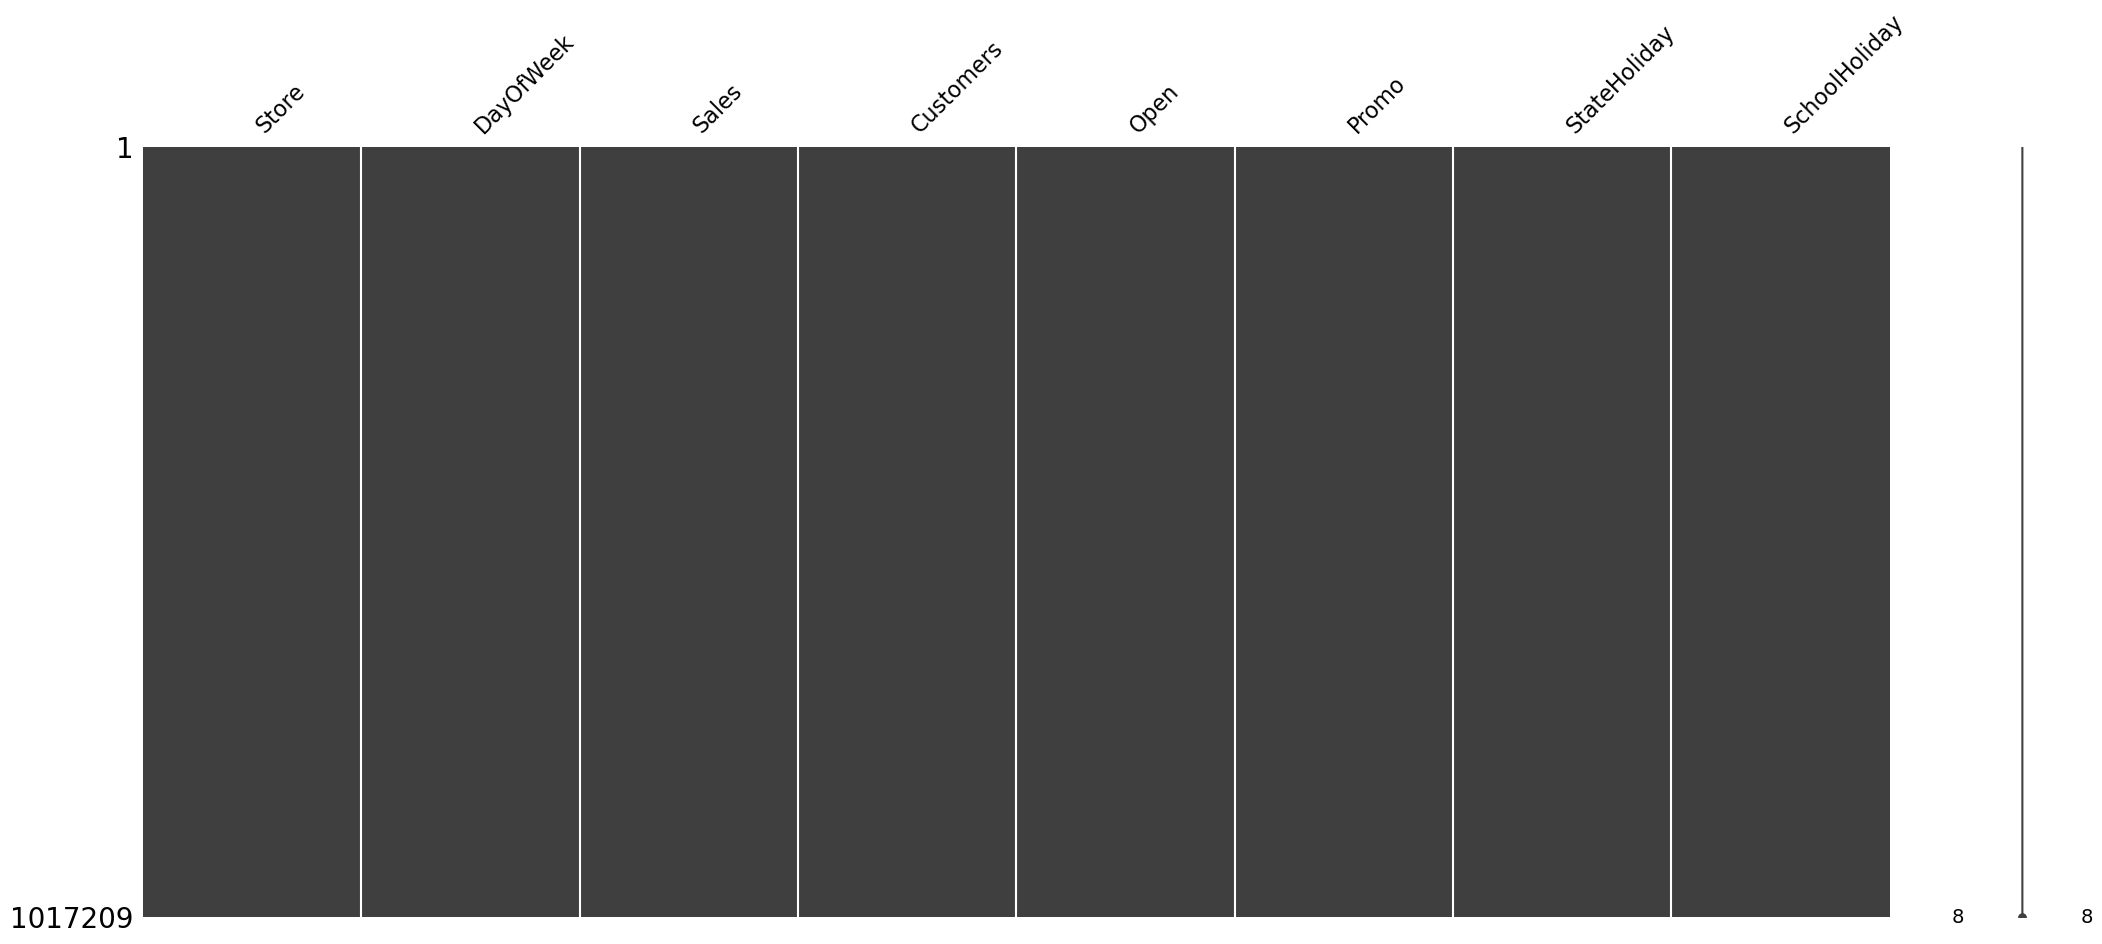

In [172]:
msno.matrix(train)
train.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN


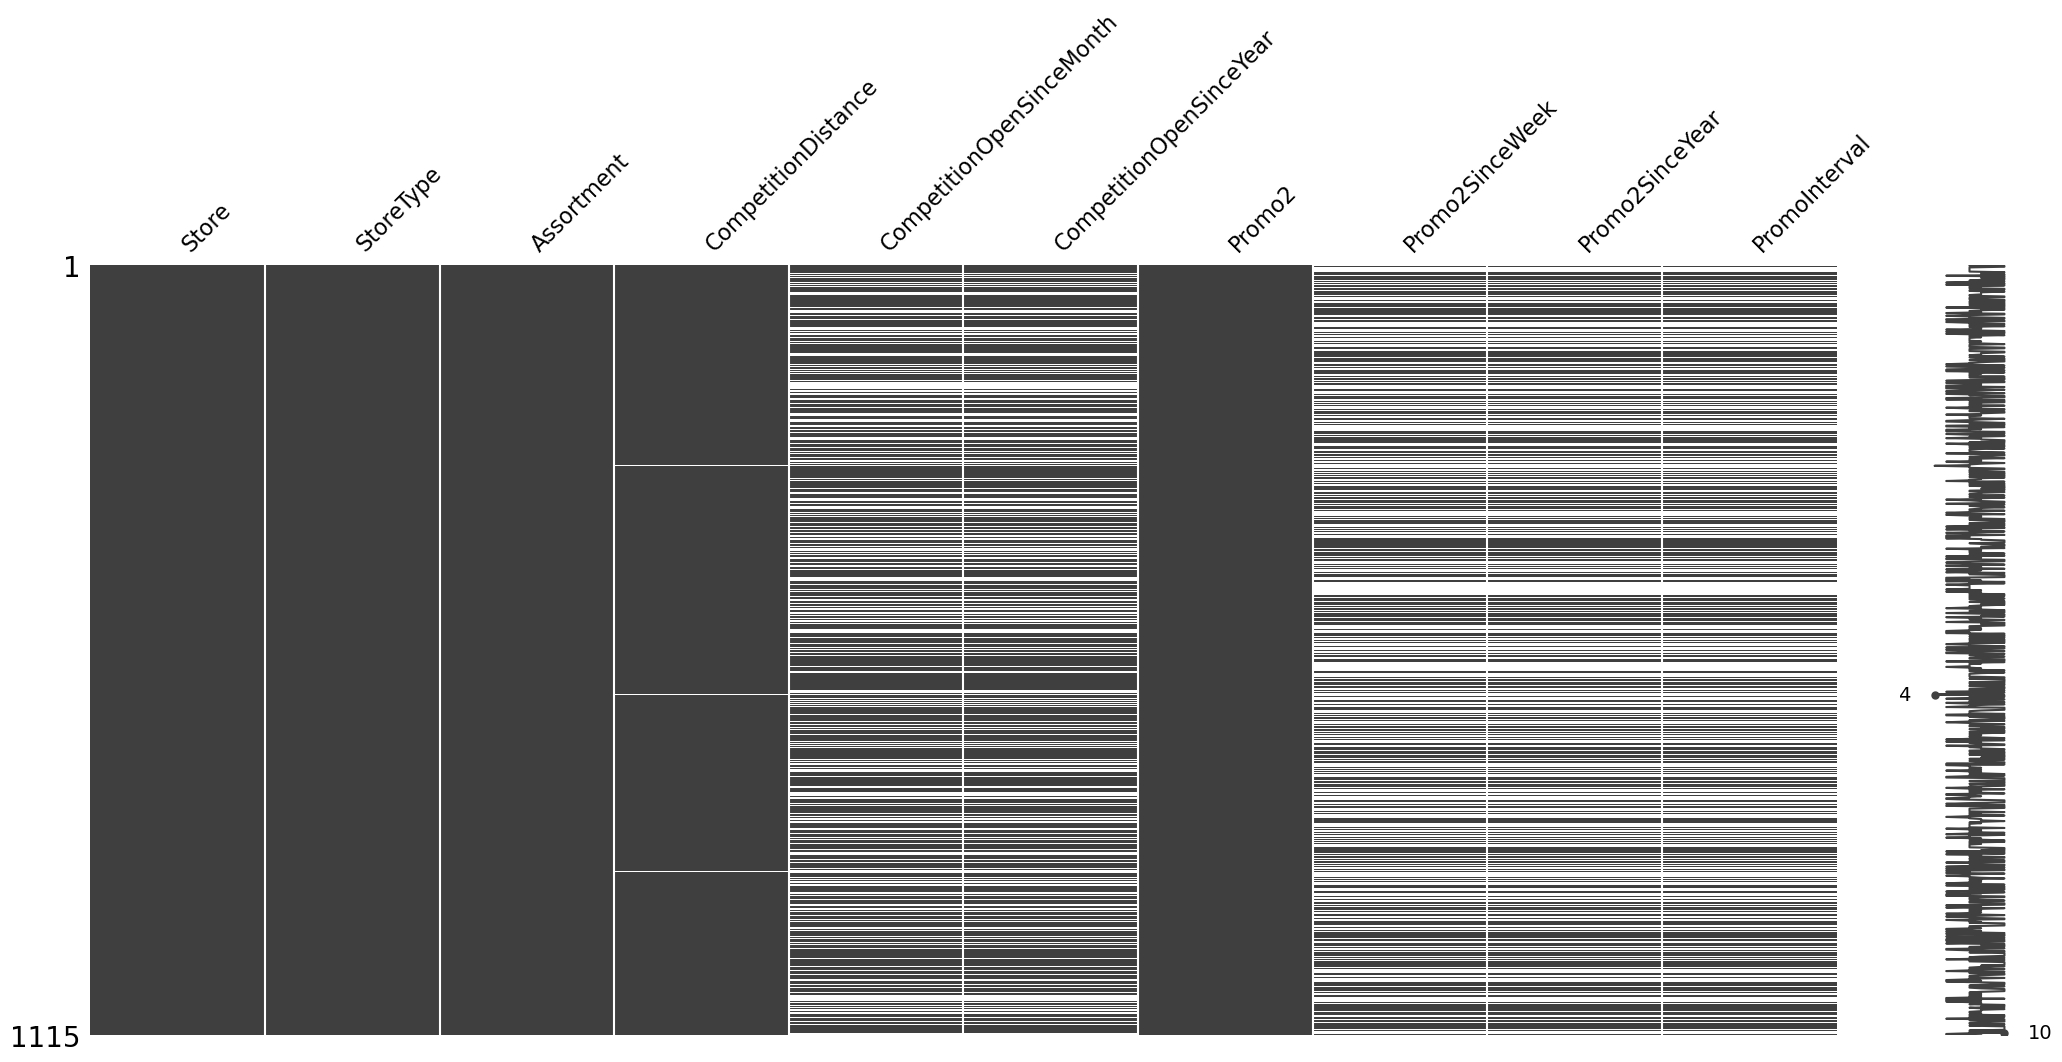

In [173]:
msno.matrix(store)
store.head(10)

In [174]:
# Lets use only the data where the store is open 
# Because we are predicting sales for open stores
opened_train = train[train['Open'] == 1]
opened_train = opened_train[opened_train['Sales'] > 0]

In [175]:
# Replace Categorical Data with Numerical Data
from sklearn.preprocessing import LabelEncoder

opened_train_copy = opened_train.copy()
object_cols = opened_train_copy.select_dtypes(include='object').columns.tolist()

for feature in object_cols:
    if feature == 'Date':
        continue
    le = LabelEncoder()
    opened_train_copy[feature] = le.fit_transform(opened_train_copy[feature])

opened_train = opened_train_copy.copy()

In [176]:
# Lets add some new features
opened_train_copy = opened_train.copy()
opened_train_copy['Year'] = opened_train_copy.index.year
opened_train_copy['Month'] = opened_train_copy.index.month
opened_train_copy['Day'] = opened_train_copy.index.day
opened_train_copy['WeekOfYear'] = pd.Index(opened_train_copy.index.isocalendar().week, dtype='int64')
opened_train_copy['SalesPerCustomer'] = opened_train_copy['Sales'] / opened_train_copy['Customers']
opened_train = opened_train_copy.copy()

In [177]:
#Lets drop the columns that are not needed
opened_train = opened_train.drop('Open', axis = 1)
opened_train = opened_train.drop('Sales', axis = 1)

# fig, ax = plt.subplots(figsize=(38,38))
# sns.heatmap(opened_train.corr(), annot = True, ax=ax)

In [178]:
store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [179]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [180]:
store_clean = store.copy()

# Lets replace the categorical data with numerical data
store_clean_copy = store_clean.copy()
object_cols = store_clean_copy.select_dtypes(include='object').columns.tolist()

for feature in object_cols:
    if feature != 'PromoInterval':
        le = LabelEncoder()
        store_clean_copy[feature] = le.fit_transform(store_clean_copy[feature])
    


store_clean_copy['Promo2SinceYear'].fillna(0, inplace=True)
store_clean_copy['Promo2StartDates'] = pd.to_datetime(store_clean_copy['Promo2SinceYear'].astype(int), format='%Y', errors='coerce') + pd.to_timedelta(store_clean_copy['Promo2SinceWeek'].mul(7).astype(str) + ' days', errors='coerce')

store_clean = store_clean_copy.copy()

# Lets fill the part of missing values
store_clean.CompetitionDistance.fillna(store_clean.CompetitionDistance.median(), inplace=True)
store_clean.CompetitionOpenSinceMonth.fillna(method='ffill', inplace=True)
store_clean.CompetitionOpenSinceYear.fillna(method='ffill', inplace=True)

def create_arr(x):
    if type(x) == str:
        return x.split(',')
    else:
        return x
store_clean.PromoInterval = store_clean.PromoInterval.apply(create_arr)

opened_train['Date'] = opened_train.index
opened_train.reset_index(drop=True, inplace=True)
opened_train = opened_train.merge(store_clean[['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']], on='Store')
opened_train.set_index('Date', inplace=True)
opened_train['MonthsSinceCompetitionOpen'] = 12 * (opened_train['Year'] - opened_train['CompetitionOpenSinceYear']) + (opened_train['Month'] - opened_train['CompetitionOpenSinceMonth'])
opened_train.drop(['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth'], axis=1, inplace=True)

In [183]:
# NEED TO OPTIMIZE THIS WITH VECTORS!!!!!!!
opened_train_copy = opened_train.copy()
opened_train_copy['Promo2'] = 0
for index, row in opened_train_copy.iterrows():
    storeId = int(row.Store - 1)
    storeRow = store_clean.iloc[int(row.Store - 1)]
    if storeRow.Promo2 == 1 and index > storeRow.Promo2StartDates and index.strftime('%b') in storeRow.PromoInterval:
      opened_train_copy.loc[index, 'Promo2'] = 1

opened_train = opened_train_copy.copy()
# NEED TO OPTIMIZE THIS WITH VECTORS!!!!!!!
    

<Axes: >

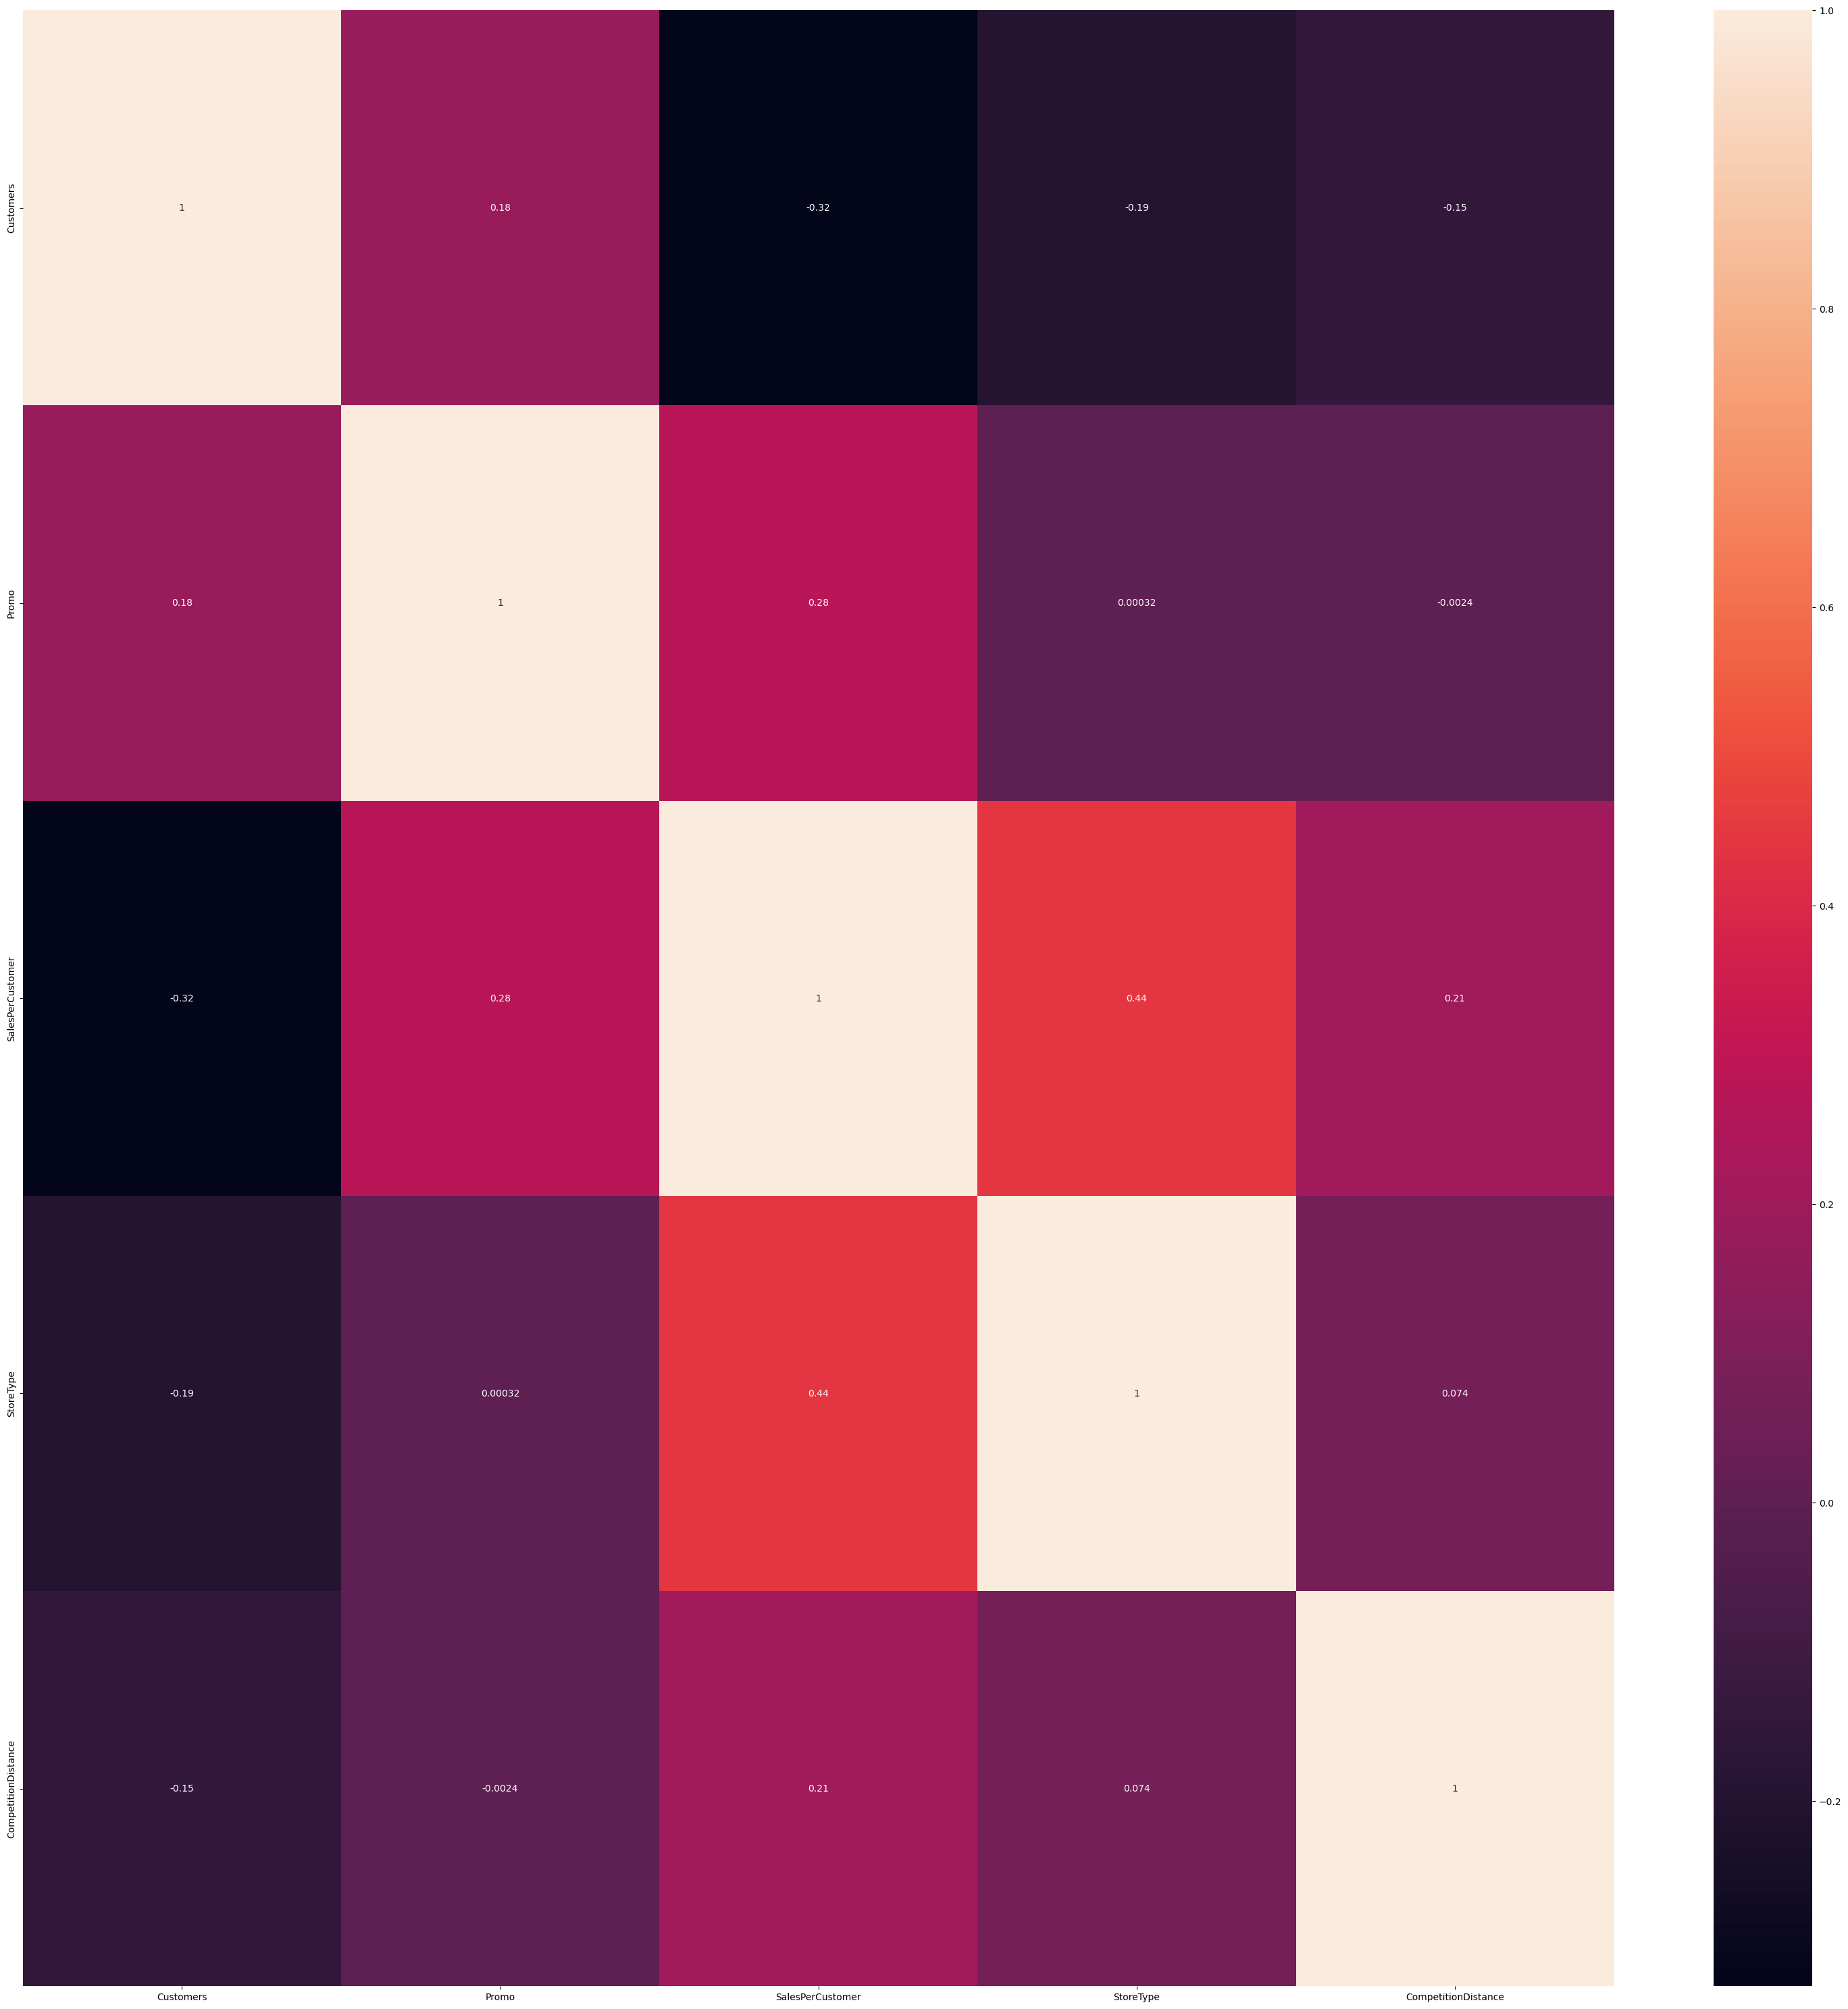

In [206]:
fig, ax = plt.subplots(figsize=(38,38))
corr = opened_train.corr()
high_corr = corr.index[abs(corr['Customers'])>0.1]
sns.heatmap(opened_train[high_corr].corr(), annot = True, ax=ax)

In [199]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

X = opened_train[['Year', 'Month', 'Day', 'WeekOfYear', 'Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'MonthsSinceCompetitionOpen', 'Promo2']]
Y = opened_train[['SalesPerCustomer', 'Customers']]

# Define the number of splits
n_splits = 5

# Initialize the TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=n_splits)

scalerX = StandardScaler()
scalerY = StandardScaler()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit the scaler on the training data and transform it
    X_train_scaled = scalerX.fit_transform(X_train)
    Y_train_scaled = scalerY.fit_transform(Y_train)

    # Transform the test data using the scaler fitted on the training data
    X_test_scaled = scalerX.transform(X_test)
    Y_test_scaled = scalerY.transform(Y_test)


In [202]:
from sklearn.linear_model import MultiTaskElasticNet
from sklearn.ensemble import RandomForestRegressor

# model = MultiTaskElasticNet(alpha=0.0001, l1_ratio=0.0001, random_state=42)
# model.fit(X_train_scaled, Y_train_scaled)

# model.score(X_test_scaled, Y_test_scaled)

model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train_scaled, Y_train_scaled)

model.score(X_test_scaled, Y_test_scaled)

0.013471483520157423

In [ ]:
# opened_train_copy = opened_train.copy()

# opened_train_copy['CompetitionOpen'] = 12 * (opened_train_copy['Year'] - opened_train_copy['CompetitionOpenSinceYear']) + (opened_train_copy['Month'] - opened_train_copy['CompetitionOpenSinceMonth'])
# opened_train_copy['CompetitionOpen'] = opened_train_copy['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)

# opened_train_copy['PromoOpen'] = 12 * (opened_train_copy['Year'] - opened_train_copy['Promo2SinceYear']) + (opened_train_copy['WeekOfYear'] - opened_train_copy['Promo2SinceWeek']) / 4.0
# opened_train_copy['PromoOpen'] = opened_train_copy['PromoOpen'].apply(lambda x: x if x > 0 else 0)

# opened_train_copy['PromoInterval'].fillna(0, inplace = True)
# opened_train_copy['IsPromoMonth'] = 0
# for interval in opened_train_copy.PromoInterval.unique():
#     if interval != 0:
#         for month in interval.split(','):
#             opened_train_copy.loc[(opened_train_copy.Month == int(month)) & (opened_train_copy.PromoInterval == interval), 'IsPromoMonth'] = 1

# opened_train_copy['StateHoliday'] = opened_train_copy['StateHoliday'].apply(lambda x: 1 if x == 'a' else 0)